# Tweet text analysis
In this part of the notebook, we will look into the text behind the tweets that American Politicians posts.
This part is composed of 5 subparts namely:
1. TF-TR Analysis for the three Communities, 
1. TD-IDF on a state level,
1. Dispersion plot
1. Sentiment Analysis
1. Subconclussion

In the first sub-part, it will be explored how the three previously extracted communities use Twitter differently with TF-TR method. Recall the three communities consists of
1. Roughly all Senators access all parties,
1. Roughly all Republican Representatives, and
1. Roughly all Democratic Representatives.
In the second sub-part, the use of words in tweets across the different states that politicians represent will be discovered using TD-IDF method.
For the third sub-part interesting word that was discovered in the previous two subparts will be shown in a dispersion plot.
The fourth sub-part will discover the sentiment of tweets across the 3 communities but also on party bases as well as it explores how the politicians feel about the selected word in the dispersion plot.
Finally, in the fifth sub-part, we will conclude our findings.

In the cell below are the necessary dependencies loaded as well as the data.

In [22]:
import pickle
import nltk
import wordcloud
import json

import pandas as pd
import itertools
import tqdm
import numpy as np

import json
import re

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [2]:
# Load dataframe containing tweets
df_tweets = pd.read_pickle('../Data/Processed/congress_cleaned_processed.pkl')

# Load dataframe with twitter handles
twitter_handles = pd.read_table('../Data/Processed/Twitter_Handles_updated.csv', sep = ',')

# Load communities 
with open('../Data/Processed/communities.json') as f:
    communities = json.load(f)

In [3]:
# Rename column in order to merge
df_tweets = df_tweets.rename(columns={'user_name': 'twitter_display_name'})
df_Full = pd.merge(df_tweets, twitter_handles, on = 'twitter_display_name')

In [4]:
def com_look_up(tw):
    try:
        return(communities[tw])
    except KeyError:
        return None

The communities from the who-follow-who graph is added.

In [5]:
df_Full['Community'] = list(map(com_look_up, df_Full['Twitter']))

In [6]:
df_Full.head(10)

user_id  twitter_display_name                  id          created_at  \
0  240760644  Rep. Paul Gosar, DDS  824768889498198016 2017-01-27 00:00:01   
1  240760644  Rep. Paul Gosar, DDS  824924576891228160 2017-01-27 10:18:40   
2  240760644  Rep. Paul Gosar, DDS  824924641991020544 2017-01-27 10:18:55   
3  240760644  Rep. Paul Gosar, DDS  824924658696859649 2017-01-27 10:18:59   
4  240760644  Rep. Paul Gosar, DDS  825027648841715715 2017-01-27 17:08:14   
5  240760644  Rep. Paul Gosar, DDS  825027648841715715 2017-01-27 17:08:14   
6  240760644  Rep. Paul Gosar, DDS  825052580623577088 2017-01-27 18:47:18   
7  240760644  Rep. Paul Gosar, DDS  825062605144338436 2017-01-27 19:27:08   
8  240760644  Rep. Paul Gosar, DDS  826193721758736384 2017-01-30 22:21:47   
9  240760644  Rep. Paul Gosar, DDS  826193721758736384 2017-01-30 22:21:47   

                                                text         retweet  \
0  good riddance we need leaders who will not und...           False   
1  including the stream protection rule which cou...    NatResources   
2  perhaps no aspect of americas economy has been...    NatResources   
3  the scope venting and flaring rule ripe for re...    NatResources   
4  we are missing 57 million people in the us bc ...  March_for_Life   
5  we are missing 57 million people in the us bc ...  March_for_Life   
6  today is #nationaldownwindersday radiation exp...           False   
7  video jan 27th is international #holocaust rem...       azcentral   
8  im incredibly proud of sarah nguyen from presc...           False   
9  im incredibly proud of sarah nguyen from presc...           False   

   retweet_count  favorite_count  in_reply_to_status_id  in_reply_to_user_id  \
0             12              18                    NaN                  NaN   
1              5               0                    NaN                  NaN   
2              6               0                    NaN                  NaN   
3              8               0                    NaN                  NaN   
4           1256               0                    NaN                  NaN   
5           1257               0                    NaN                  NaN   
6              1               4                    NaN                  NaN   
7             10               0                    NaN                  NaN   
8              7              23                    NaN                  NaN   
9              7              24                    NaN                  NaN   

    Twitter State       Party            Type           Name Community  
0  RepGosar    AZ  Republican  Representative  Paul A. Gosar        rr  
1  RepGosar    AZ  Republican  Representative  Paul A. Gosar        rr  
2  RepGosar    AZ  Republican  Representative  Paul A. Gosar        rr  
3  RepGosar    AZ  Republican  Representative  Paul A. Gosar        rr  
4  RepGosar    AZ  Republican  Representative  Paul A. Gosar        rr  
5  RepGosar    AZ  Republican  Representative  Paul A. Gosar        rr  
6  RepGosar    AZ  Republican  Representative  Paul A. Gosar        rr  
7  RepGosar    AZ  Republican  Representative  Paul A. Gosar        rr  
8  RepGosar    AZ  Republican  Representative  Paul A. Gosar        rr  
9  RepGosar    AZ  Republican  Representative  Paul A. Gosar        rr

## TF-TR word clouds

In this part, TF-TR word clouds based on the tweets across the three communities will be created. The TF-TR model is the one made by Sune in lecture week 7 but it will in this part be expanded to handle three communities.


In [7]:
# Making lists of text for republicans and democrats
se_list = df_Full.loc[df_Full["Community"] == 'se', "text"]
rr_list = df_Full.loc[df_Full["Community"] == 'rr', "text"]
dr_list = df_Full.loc[df_Full["Community"] == 'dr', "text"]

Each tweet in the party-specified lists is tokenized into individual strings using the `RegexpTokenizer`. This tokenizer ensures that all punctuations are removed from the texts.

In [8]:
# Tokenize the pages into individual strings and remove all punctuation from the list of tokens
tokenizer = nltk.RegexpTokenizer(r'\w+')

# Apply tokenizer
tokens_se = tokenizer.tokenize(" ".join([i for i in se_list if i is not None]))
tokens_rr = tokenizer.tokenize(" ".join([i for i in rr_list if i is not None]))
tokens_dr = tokenizer.tokenize(" ".join([i for i in dr_list if i is not None]))

Now stemmning of all the tokens will be carried out using the `WordNetLemmatizer` from nltk.

In [9]:
lemmatizer = nltk.stem.WordNetLemmatizer()

# Apply lemmatization
lemma_se = [lemmatizer.lemmatize(token) for token in tokens_se]
lemma_rr = [lemmatizer.lemmatize(token) for token in tokens_rr]
lemma_dr = [lemmatizer.lemmatize(token) for token in tokens_dr]

Firstly, a modified TF-TR method will be utilized on all tweets and used for creating word-clouds that characterizes the three communities found in the who-follow-who graph. The modified TF-TR is used instead of the TF-IDF as there only will be three documents that all will be very long. Therefore many words are expected to be dropped due to their IDF being 0. For a longer discussion of TF-TR see out assignment 2.

For the three communities, the TR for a term $t$ with term frequency $TF_t^{(c)}$, where community $c \in \{se, rr, dr\}$ is defined as 

$$w_t^{(se)} = \frac{TF_t^{(se)}}{TF_t^{(rr)}+TF_t^{(dr)}+k}, \quad w_t^{(rr)} = \frac{TF_t^{(rr)}}{TF_t^{(se)}+TF_t^{(dr)}+k}, \quad w_t^{(dr)} = \frac{TF_t^{(dr)}}{TF_t^{(rr)}+TF_t^{(se)}+k} $$

where $k$ is a constant which ensures the avoidance of division by zero. It has in this case been set to 1000. This is due to the regualization needed due to the document lengths as there are more than one million tweets.

With this, a TF-TR list for each community can be created where the ranking of term $t$ in community $c$ is given by $TF_t^{(c)} \times w_t^{(c)}$.

These lists will then be used for creating the so-called TF-TR word-clouds. 

For calculating the term frequency of each word in the two lists, the `FreqDist` function from nltk is used which outputs a dictionary containing the words as keys and their corresponding values are the number of times each term occurs.

In [10]:
# Term frequency for both parties
TF_se = nltk.FreqDist(lemma_se)
TF_rr = nltk.FreqDist(lemma_rr)
TF_dr = nltk.FreqDist(lemma_dr)

When caluclating the TF-TR the full list of unique words are first found and then the formular can be applied. The TF-TR lists are created as dictionaries where the words are the keys.

In [11]:
# Union the words from both parties
words = set(TF_se.keys()).union(set(TF_rr.keys())).union(set(TF_dr.keys()))

# Initilize dicts
TF_TR_se = {}
TF_TR_rr = {}
TF_TR_dr = {}

# Set constant k
k = 1000

# Populate dicts
for word in words:
    TF_TR_se[word] = (TF_se[word])/(TF_rr[word] + TF_dr[word] + k)
    TF_TR_rr[word] = (TF_rr[word])/(TF_se[word] + TF_dr[word] + k)
    TF_TR_dr[word] = (TF_dr[word])/(TF_se[word] + TF_rr[word] + k)

The TF-TR word-clouds can now created using the `wordcloud` package. This package takes dictionaries as inputs where the values are interpreted as weight. The word clouds are colored based on their party color - i.e. the Republican cloud is red and the Democrat cloud is blue and green is used for the senators.

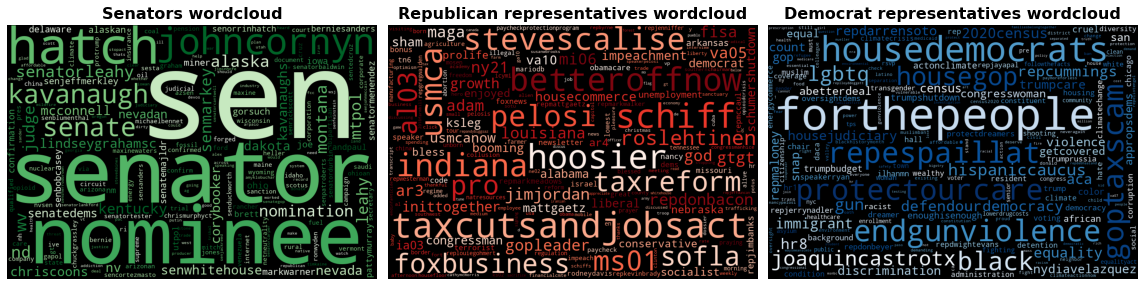

In [12]:
# Initialize plot
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize = (16,20))

# se cloud
word_cloud_se = wordcloud.WordCloud(
    colormap = 'Greens',
    background_color = 'black',
    random_state = 2,
    width = 900,
    height = 618
)
word_cloud_se.generate_from_frequencies(TF_TR_se)
plt.subplot(1, 3, 1)
plt.imshow(word_cloud_se)
plt.axis('off')
plt.title('Senators wordcloud', fontsize = 16, fontweight='bold')


# rr cloud
word_cloud_rr = wordcloud.WordCloud(
    colormap = 'Reds',
    background_color = 'black',
    random_state = 2,
    width = 900,
    height = 618
)
word_cloud_rr.generate_from_frequencies(TF_TR_rr)
plt.subplot(1, 3, 2)
plt.imshow(word_cloud_rr)
plt.axis('off')
plt.title('Republican representatives wordcloud', fontsize = 16, fontweight='bold')


# dr cloud
word_cloud_dr = wordcloud.WordCloud(
    colormap = 'Blues',
    background_color = 'black',
    random_state = 2,
    width = 900,
    height = 618
)
word_cloud_dr.generate_from_frequencies(TF_TR_dr)

# Plot them side by side
plt.subplot(1, 3, 3)
plt.imshow(word_cloud_dr)
plt.axis('off')
plt.title('Democrat representatives wordcloud', fontsize = 16, fontweight='bold')

plt.show()

So what do we see? The senators like to mention senators. There are some names of senators while sen, senator. Moreover nominee, and also nomination, is quite significant - that is probably due to the fact that in Donald Trump's presidency, where we have data,two new supreme courts judges have been nominated. And the senate has to approve those that the president nominees. 

The main word seen for the Republican representatives is *taxcutandjobsact*. The reason it is in one word is probably due to it being a twitter hashtag. It was a plan to lower the corporate tax in the US to secure more jobs. In the say theme taxreform is also seen. Again many names and states (congressional districts) are seen as well as foxbusiness, which is a classic Republican newsmedia. They also use *betteroffnow* which is probably due to the fact that there has been a Republican president so they feel that peuple are better off now. 

Moving onto the Democrat representatives *forthepeople* jump to the eye which could have been a Democrat campaign. Moreover *goptaxscam* is also seen which is probably how the Democrats feel about the Republican tax reform. LGBTQ is also seen as quite significant for the democrats. Immigrant and black is also seen - the Democrats probablt have a larger focus towards them. Once again many names are also seen. 

## TD-IDF on state level

Now we will try to carry out a TD-IDF on state level to see if we can localize some keywords that congress memebers speak about on a state level. For a more in depth explination of the tf-idf we refer to our assignment 2. First all the tweets will combined on a state level into a dictionary with states as keys as all tweets combined into one long string as values. This is done below:

In [13]:
# Group tweets by state
state_tweets = df_Full.groupby('State')['text'].apply(' '.join).to_dict()

It is desired to stem the words in this part why the `WordNetLemmatizer` from nltk is used again as above. First, though the words have to be tokenized where the same tokenizer is used. As such, all the long combined strings are combined into a token list that has been stemmed (lemmatized). This is done in one step below:

In [14]:
state_tokens = {state: [lemmatizer.lemmatize(token) for token in tokens] 
                        for state, tokens in 
                        dict(map(lambda x: (x[0], tokenizer.tokenize(x[1])), state_tweets.items())).items()
                }

With this in place let us get a quick overview over the number of tokens in each document corresponding to the text from one state.

In [24]:
with open('../data/processed/us_state_abbrev.json') as json_file:
    us_state_abbrev = json.load(json_file)
us_state_abbrev = {state : abbrev for abbrev, state in us_state_abbrev.items()}

words_per_state = {k: len(v) for k,v in state_tokens.items()}
plot_dict = {'States': list(words_per_state.keys()), 'Number of tokens': list(words_per_state.values())}
df_plot = pd.DataFrame(plot_dict)
df_plot['State Name'] = [us_state_abbrev[state_abr] for state_abr in df_plot['States']]

In [30]:
# Make plot
plt.figure(figsize=(16,8))
fig = px.bar(
    df_plot, 
    x='State Name', 
    y='Number of tokens',
    text = 'Number of tokens',
    title='Number of tokens per state'
)
fig.update_xaxes(nticks=55, tickfont=dict(size=10))
fig.update_layout(
    xaxis_tickangle=90
)
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')

fig.write_html(
    file = "../web_app/plotly_files/num_of_tokens.html", 
    full_html = False,
    include_plotlyjs='cdn'
)

fig.show()

<Figure size 1152x576 with 0 Axes>

So from this, it can be seen that the document lengths vary a lot. There are only around 10.000 tokens from American Samoa while there are more than 5.000.000 from California. If any analysis that makes a comparison between states had to be carried out this would be important to keep in mind. It is though not the case for us so instead, we leave it as an interesting fact.

Now it is time to calculate the word frequencies which is done using `FreqDist` from nltk which calculates the number of times the words appear in each document. In this case, the *raw count* will be used for the term frequency. The adjustment for the document length is not considered as the later analysis only will look at important words relative to other words in the same document as mentioned before. I.e. TF-IDF values will not be considered between documents and thus normalization would be redundant. A dictionary is used as a data structure.

In [31]:
TF_dict = {key: nltk.FreqDist(value) for key, value in state_tokens.items()}

The next step is to calculate the inverse document frequency. First, a list of all unique words across the corpus is created called `all_words`. Afterward, the IDF can be calculated as follows:
$$\operatorname{idf}(t, D)=\log \frac{N}{|\{d \in D: t \in d\}|}$$
Here the smoothing versions are not considered as $n_t$ never will be zero, as the list of all words is generated from the documents themselves. The calculation is performed below - again using a dictionary as a data structure.

In [32]:
# List of all words
all_words = set(list(itertools.chain(*state_tokens.values())))

# Calculate idf
idf = {key: np.log(len(state_tokens.keys()) / sum([tf[key] > 0 
            for k, tf in TF_dict.items()])) 
            for key in all_words
      }

With this the tf-idf can now be calculated as follows:
$$\operatorname{tf-idf}(t, d, D)=\operatorname{tf}(t, d) \cdot \operatorname{idf}(t, D)$$

A `pandas` data frame is used for this where the rows are the documents (communities) and the columns are all the words. This data frame is then populated by looping over all words and documents. By using dictionaries the lookups can be done in constant time. It is though still a time-consuming process to generate the data frame as it is very large. Therefore after the first run, we saved it in a pickle so it did not have to be regenerated.

In [33]:
# Try to load
try:
    with open('../Data/Processed/TF_IDF.pickle', 'rb') as handle:
        TF_IDF = pickle.load(handle)
        print('Pickle found!')

# Create if not found
except FileNotFoundError:
    # Storing TF-IDF in a dataframe
    TF_IDF = pd.DataFrame(index = TF_dict.keys(), columns = all_words)

    print('Pickle not found! Building dataframe')
    # Populate data frame
    for word in tqdm.tqdm(TF_IDF.columns):
        for doc in TF_IDF.index:
            TF_IDF.loc[doc, word] = TF_dict[doc][word] * idf[word]     

    # Write to pickle
    with open('../Data/Processed/TF_IDF.pickle', 'wb') as handle:
        pickle.dump(TF_IDF, handle, protocol=pickle.HIGHEST_PROTOCOL)

Pickle found!


With the TF-IDF datafarme caculatedthe shape can be checked.

In [34]:
print(TF_IDF.shape)

(55, 382297)


So the 55 corresponds to the 55 states (remember overseas territories are included). More there are 382297 unique tokens which is A LOT. Here one should remember that no filtering has been done except stemming so many of these can be names, spelling errors, etc. Let's see how many words are found in all documents, which is where the idf is 0:

In [35]:
len([word for word, idf in idf.items() if idf == 0])

958

So that is only 958 of these words are found in all *documents*. Here one should though remember that there are a total of 55 documents and the shortest only has less than 10.000 tokens why it makes sense that not very many are found. The advantage of the TF-IDF is stat words used across most states still will be regularized.

### Word clouds of results

Now the TF-IDF is converted to word clouds on the state level and it is plotted in a grid. A dictionary to show the full state name in the plot in first defined before generating the word clouds and displaying them:

In [36]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

# thank you to @kinghelix and @trevormarburger for this idea
abbrev_us_state = dict(map(reversed, us_state_abbrev.items()))

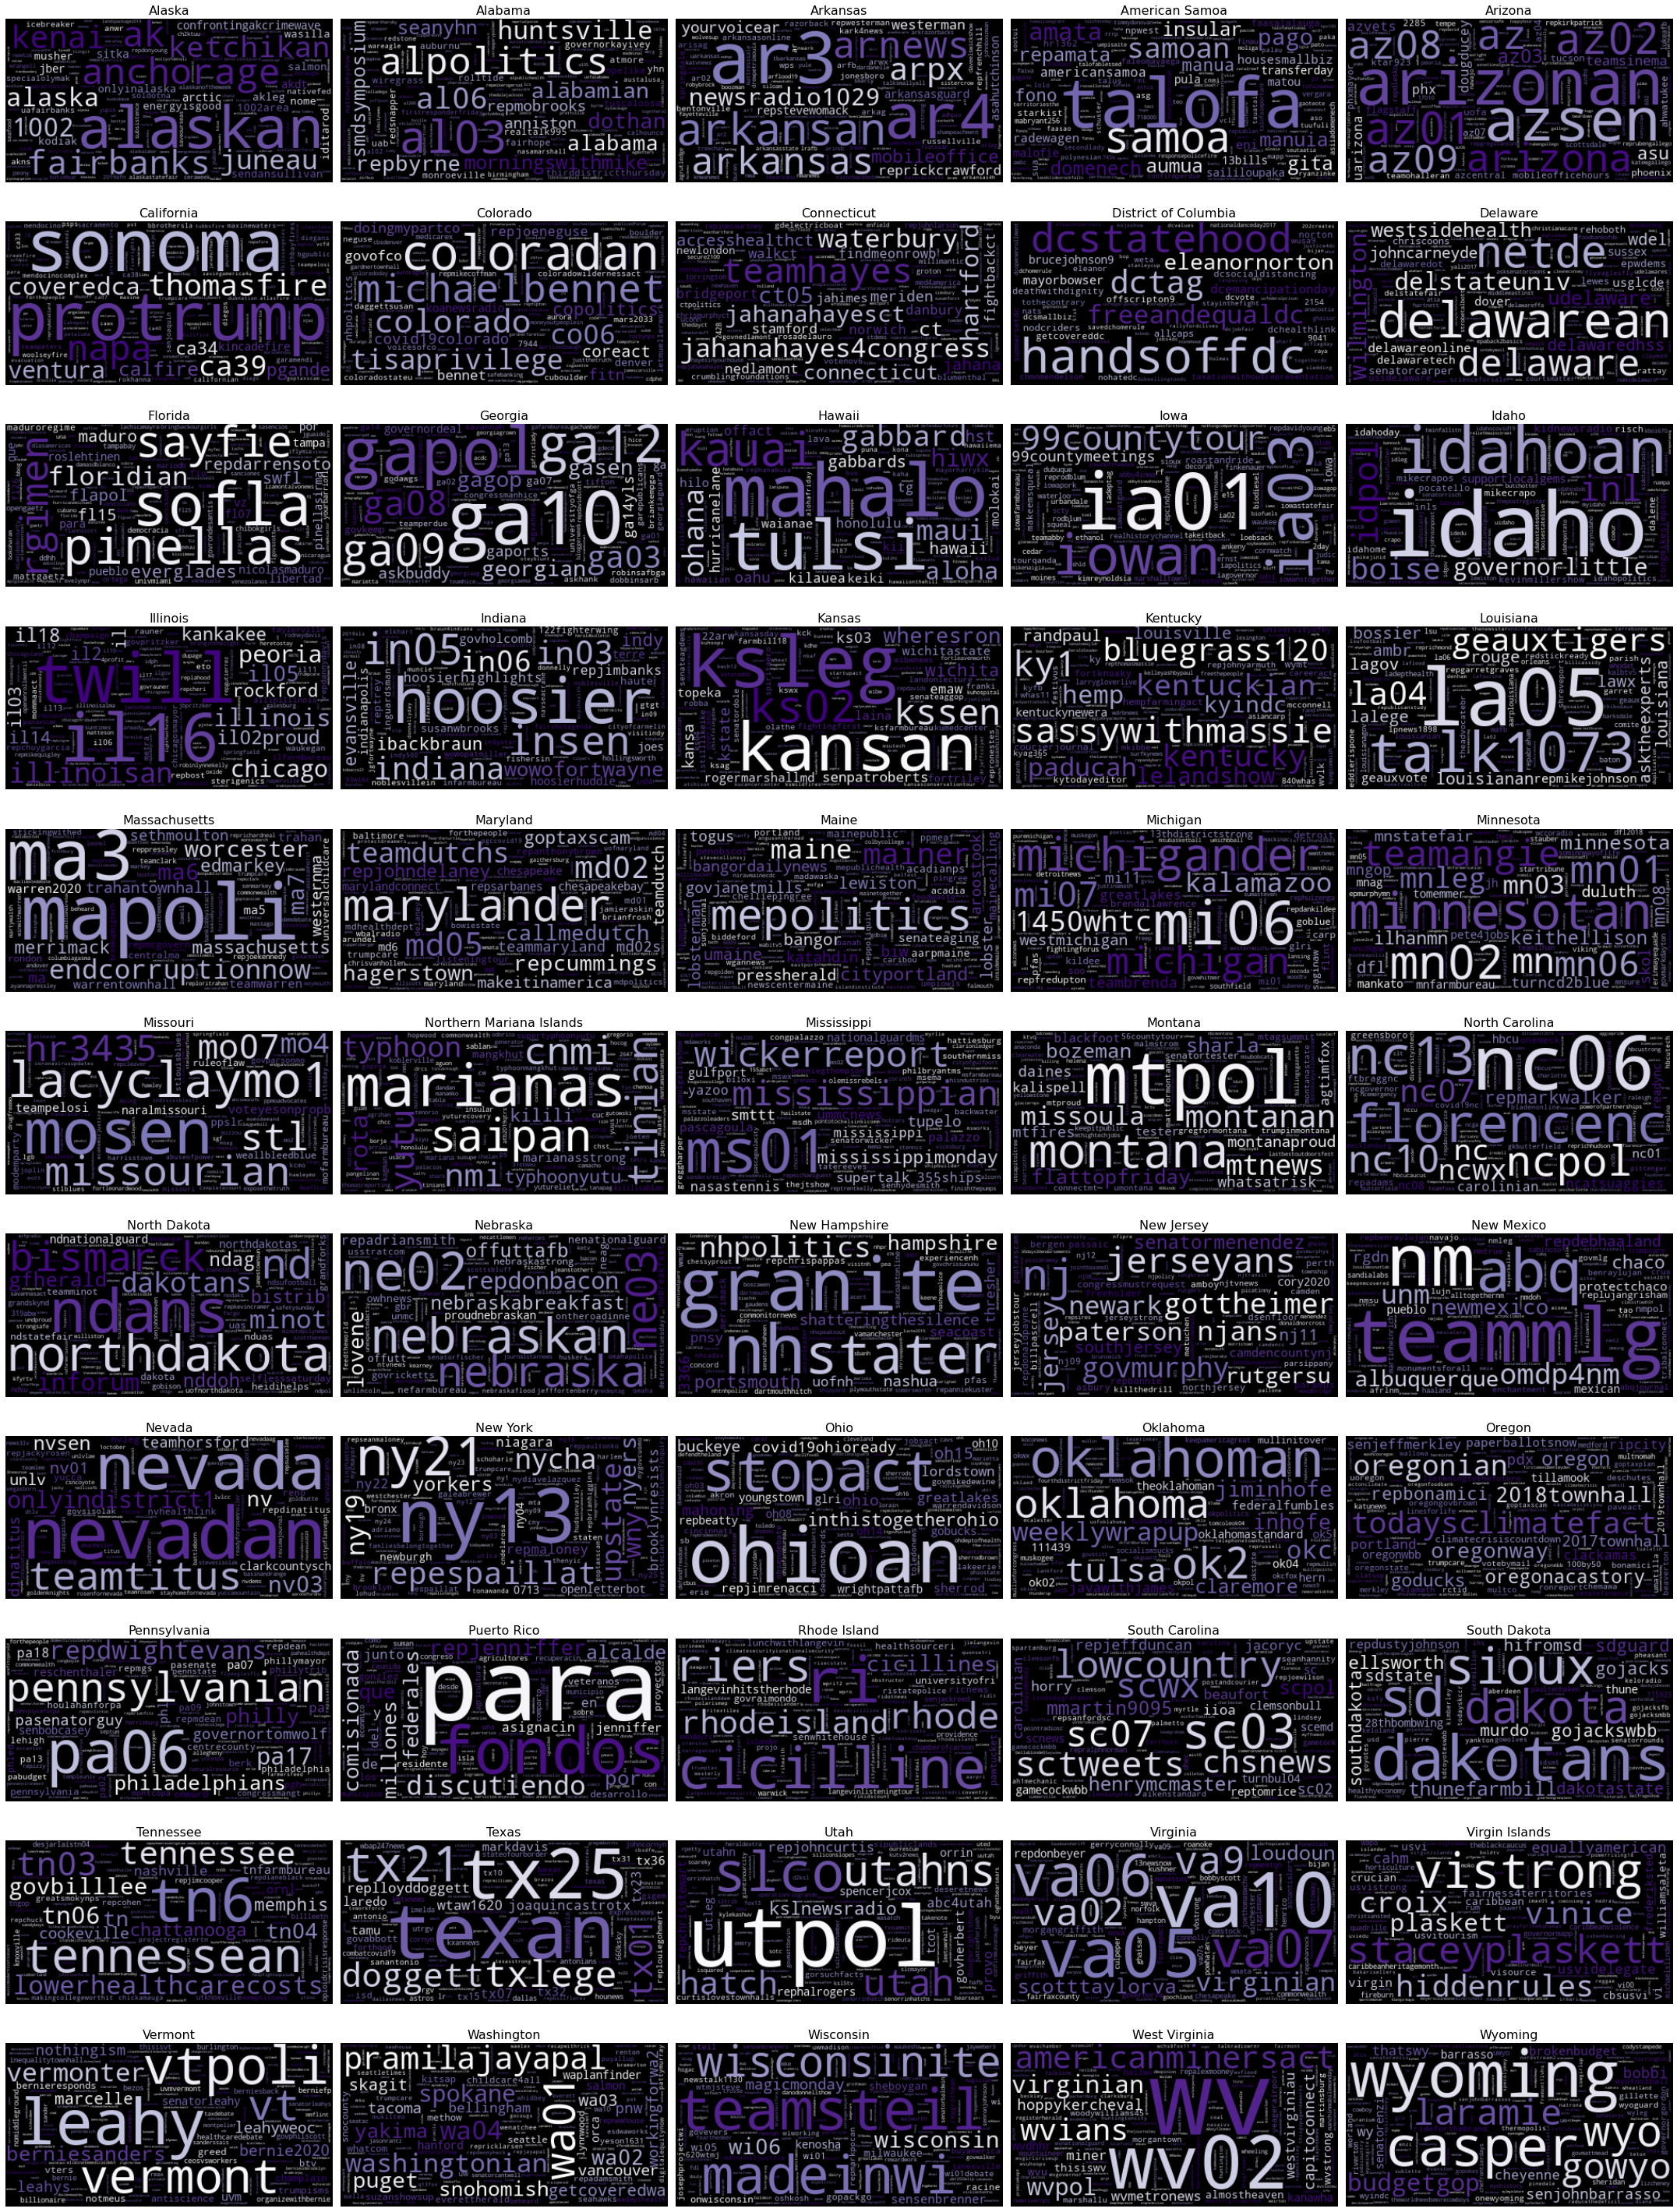

In [37]:
# Initilize plot
fig, axs = plt.subplots(11, 5, sharey=True, tight_layout=True, figsize = (30,40))

# Loop over the 8 communities
for p, (state, words) in enumerate(dict(zip(TF_IDF.index, TF_IDF.to_dict(orient = 'records'))).items()):
    import wordcloud # Import wordcloud here due to some bug
    
    # Generate wordcloud
    wordcloud = wordcloud.WordCloud(colormap = "Purples", background_color = "black")
    wordcloud.generate_from_frequencies(frequencies=words)
    
    # Plot it
    axs[p//5, p%5].imshow(wordcloud, interpolation="bilinear")
    axs[p//5, p%5].axis("off")
    axs[p//5, p%5].set_title(abbrev_us_state[state], fontsize = 16)

 
plt.show()

In general, across all 55 states, their own state name, demonym, and some congressional districts are mentioned often. Some of the districts mentioned are some of those that are more fought for in elections so they are mentioned more. Moreover, many names of politicians from those stats are seen. Some other interesting words to spot in the list:

- In American Samoa *talofa* is very significant. It turns out that it is a greeting in Samoan.
- In California Sonoma is a county that is often hit hard by wildfires. This has clearly been mentioned a lot.
- In New Hampshire granite is pretty much the most *important* word. New Hampshire is often called the Granite State due to its vast amount of granite quarries.
- In Kentucky, "Bluegrass120" is very popular. After some research, it was term to describe all 120 district in Kentucky used by a campaign from Mitch McConnell who is a senator from Kentucky and house majority leader in the Senate.
- In Oregon todaysclimatefact pops up. When analyzing the politicians per state it was seen that Oregon is very Democratic - maybe some Demoracts are disagreeing with the climate change doubters.

## Dispersion plot

In this part of the text-analysis, a dispersion plot will be created to see how different words are used across the time period of almost 3 and a half years. 
Using some selected keywords it is possible to see when different words trend based on what the politicians tweet. 
In order to carry out this analysis, all the tweets will have to be merged into one long string ordered by time. This is done below.

In [38]:
df_Full_sorted_time = df_Full.sort_values(by = 'created_at')
words_sorted_text = nltk.Text(tokenizer.tokenize(' '.join(df_Full_sorted_time.text)))

Notice that lemmatized is not used due to words that will be investigated are not relevant for lemmatizing. As an example, covid does not change grammatically. The list of tokens is also converted to a `nltk.Text` format.

Now the dispersion plot can actually be made using the [inbuilt method in nltk](https://www.nltk.org/_modules/nltk/draw/dispersion.html). It does though lack the functionality of having manual x-ticks as we would like here since we would rather show time as ticks compared to word index in the text. Therefore a slightly modified version has been implemented below which allows for this. The functionality is fully based on the one from nltk.

In [39]:
def dispersion_plot(text, words, xticks = None, xlabels = None):
    '''
    Slightly modified version of the dispersion plot function from nltk to allow for custom xticks
    '''
    text = list(text)
    words.reverse()

    points = [
        (x, y)
        for x in range(len(text))
        for y in range(len(words))
        if text[x] == words[y]
    ]
    if points:
        x, y = list(zip(*points))
    else:
        x = y = ()

    # Make plot
    pylab.plot(x, y, "b|", scalex=0.1)
    pylab.yticks(list(range(len(words))), words, color="b")
    pylab.ylim(-1, len(words))
    pylab.title("Lexical Dispersion Plot")
    pylab.xlabel("Word Offset")
    if xticks is not None:
        pylab.xticks(ticks=xticks, labels=xlabels)
    pylab.show()

Now the dispersion plot can be created by passing the text and some key words. We would though also like to create xticks. This is done by storing info on what each index in the text corresponds to in time. By then manually selecting some ticks it can be looked up what date it corresponds to and they can be plotted to give a nice overview of time.

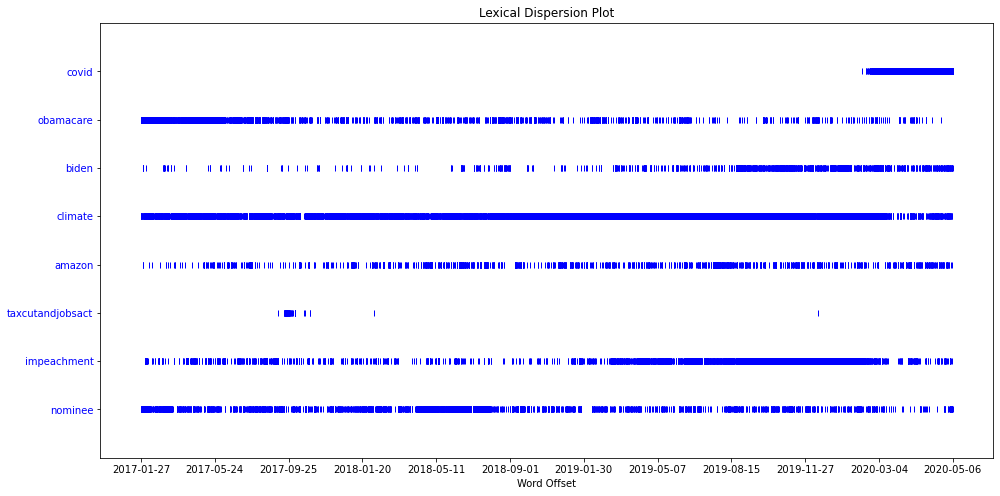

In [40]:
# Calculating x-ticks
tweet_lenghts = np.cumsum([len(tokenizer.tokenize(text)) for text in df_Full.text])
ticks = np.round(np.linspace(0, tweet_lenghts[-1], 12))
index = [np.where(tweet_lenghts >= t)[0][0] for t in ticks]
labels = [df_Full_sorted_time.iloc[idx]['created_at'].date() for idx in index]

# Make dispersion plot
plt.figure(figsize = (16,8))
dispersion_plot(words_sorted_text, ['covid', 'obamacare', 'biden', 'climate', 'amazon', 'taxcutandjobsact', 'impeachment', 'nominee'], ticks, labels)

Some short key takeaways of the selected words:

- *Covid* starts getting relevant around the start of 2020 without any activity before. This is not surprising based on the fact that it was here it starting getting to the news where it only was in China.
- *Obamacare* has been a focus across the full period but especially it has been in focus at the start of Donald Trump's presidency where he wanted to repel it.
- *Biden* has grown much more into focus as election day came closer. It could be interesting if tweets were available up till the present day to see how it looked there. He has though been in focus since the summer of 2019 - they have long elections in the United States.
- *Climate* has been in heavy focus across the full period.
- *Amazon* which is both the rain forest in South America, but more important also the world's largest online retailer is also mentioned across the full period but it seems to be mentioned more frequently as there has been a larger focus on their work environment.
- The *Schumer Shutdown* can also be located quite clearly in time using this method and it can be seen that it *trending* twice ' in late 2017 and 2018 - in the given time period.
- *Impeachment* has really 'gained traction' in the latter half of our time frame which must come from all possible cases against President Trump.
- *Nominee* is generally mentioned a lot across the time period but there are some spikes. On April 7, 2017 and October 6, 2018 new supreme court judges were nominated - on July 31, 2018 a previous judge retired. So it has in general been in the first half of our time period that it has been a relevant subject and graph also reveals that.

## Sentiment Analysis

Let's move onto a sentiment analysis of the tweets. The analysis will be centered around the three communities found previously. 
To carry out this analysis the sentiment scores used in class found [here](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) are also used here. 
The data set is firstly loaded and the words and scores are then converted to a dictionary to allow for quick look-ups.

In [41]:
# Load sentiment data
sentiment_table = pd.read_table('../Data/Processed/Sentiment.txt', delimiter="\t")

# Get relevant
sentiment_dict = dict(zip(sentiment_table['word'],sentiment_table['happiness_average']))

Below a utility-function called `sentimentcalc` is implemented. It takes a list of tokens and returns the mean of the sentiment scores or `None` if none of the tokens have a sentiment scores.

In [42]:
def sentimentcalc(tokens):       
        # Get all words with a sentiment score from the token list
        sents = [sentiment_dict[word] for word in tokens if word in sentiment_dict.keys()]
        
        # Return nan if no words have a score
        if len(sents) == 0:
            return None
        
        # Else return the mean of scores
        else:
            return np.mean(sents)

First all tweets for the three communities are found. This tokenization and lemmatization is done as with the TF-IDF for the states. Afterwards the sentiment score for the three communities is calculated and printed.

In [43]:
# Get combined tweets per community
com_tweets = df_Full.groupby('Community')['text'].apply(' '.join).to_dict()

# Get lemmatized tokens
com_tokens = {com: [lemmatizer.lemmatize(token) for token in tokens] 
                    for com, tokens in 
                    dict(map(lambda x: (x[0], tokenizer.tokenize(x[1])), com_tweets.items())).items()
            }

# Calculate average scores
Sent_avg_score = {com: sentimentcalc(tokens) for com, tokens in com_tokens.items()}
print(Sent_avg_score)

{'dr': 5.449711124244303, 'rr': 5.496102069439885, 'se': 5.452581491482579}


The scores are seen to be fairly close to eachother with values around close to 5.5. Here, it should be noted that a neutral score is 5, so that means that all three communities are slightly positive.

It would be interesting to know how the communities feel about different topics. Therefore two functions are implemented. The first is called `get_avg_sent_for_com` and it takes a word/phrase and calculates the average sentiment score on a community-level based on all tweets where this word/phrase is included. The second function is called `get_avg_sent_multiple` and it takes a list of words/pharses and applies the `get_avg_sent_for_com` on all elements in the list and returns the results as a dataframe. This makes it easy to get an overview of different words.

In [44]:
def get_avg_sent_for_com(word):
    # Get sub data frame
    sub_df = df_Full[df_Full['text'].str.contains(word)][['text', 'Community']]

    # Group tweets by state
    com_tweets = sub_df.groupby('Community')['text'].apply(' '.join).to_dict()

    # Get lemmatized tokens
    com_tokens = {com: [lemmatizer.lemmatize(token) for token in tokens] 
                        for com, tokens in 
                        dict(map(lambda x: (x[0], tokenizer.tokenize(x[1])), com_tweets.items())).items()
                }

    # Calculate scores
    Sent_score = {com: sentimentcalc(tokens) for com, tokens in com_tokens.items()}

    # Return scores
    return Sent_score


def get_avg_sent_multiple(word_list):
    # Init dataframe to return
    scores_df = pd.DataFrame(data=0, index=word_list, columns=['se', 'rr', 'dr'])

    # Loop over all words
    for word in word_list:
        # Get scores
        scores = get_avg_sent_for_com(word)

        # Populate
        scores_df.loc[word, 'se'] = scores['se']
        scores_df.loc[word, 'rr'] = scores['rr']
        scores_df.loc[word, 'dr'] = scores['dr']

    # Return df
    return scores_df

The function `get_avg_sent_multiple` is now used on a list of words to get an overview of how the three communities *feel* towards these topics. Many of the words selected relates to the previous analyses.

In [45]:
sd = get_avg_sent_multiple(['covid', 'obamacare', 'trumpcare', 'biden', 'climate', 'amazon', 'taxcutandjobsact', 'impeachment', 'china', 'wall', 'mexico', 'nominee'])
sd

se        rr        dr
covid             5.448427  5.457984  5.445684
obamacare         5.352579  5.388522  5.298308
trumpcare         5.298128  5.422571  5.310299
biden             5.380261  5.264630  5.416168
climate           5.416446  5.510276  5.444240
amazon            5.492679  5.583696  5.494438
taxcutandjobsact  5.564140  5.533015  5.569412
impeachment       5.329586  5.306957  5.351386
china             5.385126  5.408563  5.386268
wall              5.337919  5.373220  5.329724
mexico            5.505136  5.523487  5.456053
nominee           5.375035  5.483819  5.382862

In general, it is seen sentiment scores for the community are slightly positive, and taking the average sentiment per community into account they seem even more neutral with values being fairly close to the average. 

Some of the interesting takeaways are highlighted below:

- The community of primarily democratic representatives is more negative again *Obamacare* compared to the two other communities. A reason for this can be that talk about repelling it has been more relevant in the time frame that we use. 
- The Democrats and senators are more positive against Biden which is not surprising as he is - at the moment of writing - President-elect for the Democrats.
- The Republicans are most negative against *impeachment* which is not surprising as it is expected that most tweets with impeachment are related to the impeachment against President Trump.
- On the other hand, The Republicans are the most positive for *wall* and *nominee*. Wall is expected to refer to the wall that President Trump would build towards Mexico (which can be the reason they are also most positive for Mexico). Nominee is probably - as discussed - relating to the supreme court judges that Trump has nominated who are more towards to conservative side of the spectrum.

### How do they *talk* to eachother

The next analysis will focus on how positive the politicians are when tagging each other. This will done be by looking at the sentiment in tweets where one politician tag another. To start off a sub data frame will be created where the Twitter-handle and the text is extracted:

In [46]:
# Extract sub df
Handle_Tweet_df = df_Full[['Twitter','text']]

Now all tags in the graph is found using a regex since another user is tagged using '@'. This is added as new columns:

In [47]:
# Find tags
Handle_Tweet_df['tags'] = [re.findall('(?<=@)\S+',tw) for tw in Handle_Tweet_df['text']]

/Users/mikkelgronning/opt/anaconda3/envs/social_graphs_project/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



All Twitter handles are now converted to lower to allow for matching in the tweets that already has been lowered.

In [48]:
# Convert handles to lower
Handle_Tweet_df['Twitter'] = [handle.lower() for handle in Handle_Tweet_df['Twitter']]

/Users/mikkelgronning/opt/anaconda3/envs/social_graphs_project/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Now all tags that is not in the list of politicians are removed as they are irrelevant for this analysis:

In [49]:
# Get list of handles
congress_members_lower = set(Handle_Tweet_df['Twitter'])

# Filter tags
Handle_Tweet_df['tags'] = [[tag for tag in tags if tag in congress_members_lower] for tags in Handle_Tweet_df['tags']]

/Users/mikkelgronning/opt/anaconda3/envs/social_graphs_project/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



For many of these tweets their are no tags of politicians from our data. These are filtered out.

In [50]:
# Filter out tweets with no relevant tags
Handle_Tweet_df = Handle_Tweet_df[[len(tags)>0 for tags in Handle_Tweet_df['tags']]]

Now a dataframe is created with politicians tweeting as indecies and tags as columns. The element at $i,c$ is then the merged tweets (so one long string) where politician $i$ has tagged politician $c$.

In [51]:
# Init dataframe
Text_df = pd.DataFrame(
    data = '',
    index = set(Handle_Tweet_df['Twitter']),
    columns = set([tags for tag in Handle_Tweet_df['tags'] for tags in tag])
)

# Populate dataframe
for row in tqdm.tqdm(Handle_Tweet_df.iterrows()):
    Text_df.loc[row[1]['Twitter'], row[1]['tags']] += row[1]['text']+' '

226377it [07:36, 496.03it/s]


For all elements the sentiment score is now calculated as seen below:

In [52]:
# Define function
def tokenize_tweet_calc(tweets):
    tokens = tokenizer.tokenize(tweets)
    return sentimentcalc(tokens)

# Apply it to all elements
Text_df_sent = Text_df.applymap(tokenize_tweet_calc)

With this in place the politicians from each community that is present in the `Text_df_sent` data is extracted as seperate communities.

In [53]:
# Index community
communities_dict_idx = {c: [politician.lower() for politician, community in communities.items() 
                            if community == c if politician.lower() in Text_df_sent.index] 
                            for c in set(communities.values())}

# Column community
communities_dict_col = {c: [politician.lower() for politician, community in communities.items() 
                            if community == c if politician.lower() in Text_df_sent.columns] 
                            for c in set(communities.values())}                            

Now a new 3x3 data frame is created with communities as indecies and columns. Element $i,c$ then corresponds to the average sentiment where communty $i$ tags communty $c$.

In [54]:
# Init df
Sentiment_mentions = pd.DataFrame(data = None, index = communities_dict_idx.keys(), columns = communities_dict_col.keys())

# Populate df
for idx in Sentiment_mentions.index:
    for col in Sentiment_mentions.columns:
        Sentiment_mentions.loc[idx, col] = Text_df_sent.loc[communities_dict_idx[idx],communities_dict_col[col]].stack().mean()

Let's have a look at the results:

In [55]:
# Print results
Sentiment_mentions

dr       rr       se
dr  5.52306  5.48723  5.49105
rr  5.51957  5.53238  5.50991
se  5.68092  5.72002  5.51831

Interestingly the politicans are more positive here than their general average sentiment. The Democrats and Republicans are fairly consistent with a slight preference towards their own party. Looking at the senators it is quite interesting to see that they are negative towards them selves compared to the representatives. 

It is suspected that this can be due to the fact the the senator community includes senators from both parties. Therefore we will try to split this community into two - one with Republicans and one with the Democrats and the Independents.

In [56]:
# Init dict
communities_sen_split = {}

# Populated
for politician, com in communities.items():
    if com == 'se':
        try: 
            party = df_Full[df_Full['Twitter'] == politician]['Party'].iloc[0]
            if party == 'Republican':
                communities_sen_split[politician] = 'rs'
            else:
                communities_sen_split[politician] = 'ds'
        # Skip if not in data
        except IndexError:
            continue
    else:
        communities_sen_split[politician] = com

This new dict is split as before:

In [57]:
# New updated dicts 
communities_dict_idx_up = {c: [politician.lower() for politician, community in communities_sen_split.items() 
                            if community == c if politician.lower() in Text_df_sent.index] 
                            for c in set(communities_sen_split.values())}

communities_dict_col_up = {c: [politician.lower() for politician, community in communities_sen_split.items() 
                            if community == c if politician.lower() in Text_df_sent.columns] 
                            for c in set(communities_sen_split.values())}                            

And a new data frame is created - now 4x4 due to the senator split.

In [58]:
# Init new df
Sentiment_mentions_up = pd.DataFrame(data = None, index = sorted(communities_dict_idx_up.keys()), columns = sorted(communities_dict_col_up.keys()))

# Populate df
for idx in Sentiment_mentions_up.index:
    for col in Sentiment_mentions_up.columns:
        Sentiment_mentions_up.loc[idx, col] = Text_df_sent.loc[communities_dict_idx_up[idx],communities_dict_col_up[col]].stack().mean()

# Print results
Sentiment_mentions_up

dr       ds       rr       rs
dr  5.52306  5.50838  5.48723  5.44685
ds  5.71652  5.51745  5.91191  5.52731
rr  5.51957  5.49621  5.53238  5.51917
rs  5.52259  5.51997  5.54933  5.51087

It is now seen that it is in general the Democratic senators that are very positive - and surprisingly it is especially towards the Republican Representatives. The Republican senators are mor more compareable to the Republican representatives. It can also be seen that the representatives are slightly more positive towards the senators from their own party. 

## Subconclussion

In this part various measures of natural language processing has been used to analyse the tweets taking a start in the communities found in the *Who-follow-who* graph. First TF-TR was carried out on the full set of tweets across the three communities to find important words in the communities. The results were illustrated as word clouds. Some of the words that was seen did make sense but in general it was dominated by names. Afterwards TF-IDF was carried out on a state level - leading to 55 *documents* - where word clouds again was used to illustrate the results. Some meaningfull take aways could be found even though names again were dominant. We also created a lexical dispersion plot to see how the usage of some words varied over in time where many of the results made sense thinking back on the last four years of American politics if one follows that.

The last analysis was focused on sentiment of the tweets - again based on the communities. Here we investigated how the communities *felt* towards different words where small differences could be seen. Lastly it was also investigated how positive the politicians wrote when tagging eachother. Interestingly Democratic senators were found of Republican representatives but besides that the results were as expected - but the differences were fairly minor.